<a href="https://colab.research.google.com/github/ajw1587/Pytorch_Study/blob/main/Faster_R_CNN_RPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from PIL import Image

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print(device)

cuda Tesla K80


# **Read and Resize Image**

(1333, 2000, 3)


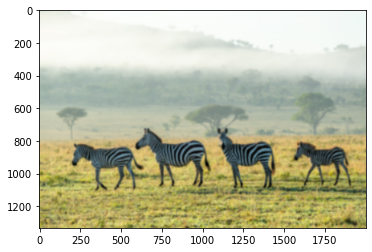

In [ ]:
# Data 가져오기 zebras.jpg
origin_img = cv.imread('/content/drive/MyDrive/논문/zebras_2000x1333.png')
origin_img = cv.cvtColor(origin_img, cv.COLOR_BGR2RGB)
print(origin_img.shape)

plt.imshow(origin_img)
plt.show()

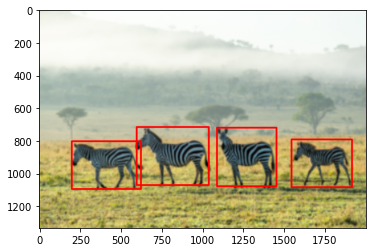

In [ ]:
# BBox, labels 선언해주기 - x1, y1, x2, y2
origin_bbox = np.array([[200, 802, 623, 1094], [597, 715, 1038, 1070], 
                  [1088, 719, 1452, 1077], [1544, 791, 1914, 1083]]) 
labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra

copy_img = np.copy(origin_img)
for i in range(len(origin_bbox)):
  cv.rectangle(copy_img, (origin_bbox[i][0], origin_bbox[i][1]), (origin_bbox[i][2], origin_bbox[i][3]), color=(255, 0, 0), thickness=10)

plt.imshow(copy_img)
plt.show()

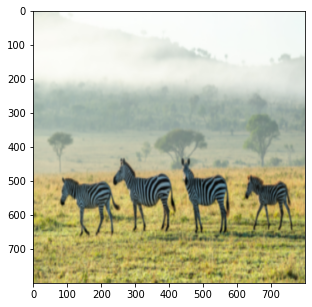

In [ ]:
# Resize Image

img = cv.resize(origin_img, dsize=(800,800), interpolation=cv.INTER_CUBIC)
plt.figure(figsize=(5,5))
plt.imshow(img)
# plt.grid(True, color='blue')
plt.show()

w_ratio : 0.4
h_ratio : 0.6001500375093773

[[ 80 481 249 656]
 [238 429 415 642]
 [435 431 580 646]
 [617 474 765 649]]


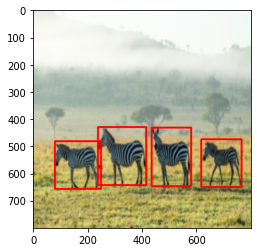

In [ ]:
# Resize BBox
w_ratio = 800/origin_img.shape[1]
h_ratio = 800/origin_img.shape[0]

print('w_ratio : {}'.format(w_ratio))
print('h_ratio : {}\n'.format(h_ratio))

ratio_list = [w_ratio, h_ratio, w_ratio, h_ratio]
bbox = []

for box in origin_bbox:
  box = [int(a*b) for a,b in zip(box, ratio_list)]
  bbox.append(box)

bbox = np.array(bbox)
print(bbox)

copy_img = np.copy(img)
for i in range(len(bbox)):
  cv.rectangle(copy_img, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(255, 0, 0), thickness=5)
plt.imshow(copy_img)
plt.show()

## **Create Extractor Model**

In [ ]:
# Feature extractor

model = torchvision.models.vgg16(pretrained=True).to(device)
features = list(model.features)
print(len(features))
for i, layer in enumerate(features):
  print('{}th Layer : {}'.format(i, layer))

31
0th Layer : Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1th Layer : ReLU(inplace=True)
2th Layer : Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3th Layer : ReLU(inplace=True)
4th Layer : MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5th Layer : Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6th Layer : ReLU(inplace=True)
7th Layer : Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8th Layer : ReLU(inplace=True)
9th Layer : MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10th Layer : Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11th Layer : ReLU(inplace=True)
12th Layer : Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13th Layer : ReLU(inplace=True)
14th Layer : Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15th Layer : ReLU(inplace=True)
16th Layer : MaxPool2d(kernel_size=2, stride=2

In [ ]:
# Collect required layers

test_img = torch.zeros((1, 3, 800, 800)).float()
print(test_img.shape)

req_features = []
output = test_img.clone().to(device)

for feature in features:
  output = feature(output)
  if output.size()[2] < 800//16:
    break
  req_features.append(feature)
  output_channels = output.size()[1]

print(len(req_features))
print(output.shape)
print(output_channels)

torch.Size([1, 3, 800, 800])
30
torch.Size([1, 512, 25, 25])
512


In [ ]:
# Create Extractor Model
extractor = nn.Sequential(*req_features)

# test
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
output_feature = extractor(imgTensor)

print(output_feature.shape)

torch.Size([1, 512, 50, 50])


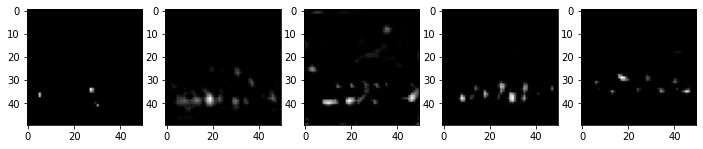

In [ ]:
# Visualize output_feature
imgs = output_feature.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4)) # figsize=전체사이즈
no = 1

for i in range(5):
  fig.add_subplot(1, 5, no)
  plt.imshow(imgs[i], cmap='gray')
  no += 1

plt.show()

#**Generate Anchors Boxes**

In [ ]:
feature_size = 800 // 16
print('feature_size : {}\n'.format(feature_size))

ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print('ctr_x len : {}'.format(len(ctr_x)))
print('ctr_x : {}\n'.format(ctr_x))

print('ctr_x len : {}'.format(len(ctr_y)))
print('ctr_x : {}'.format(ctr_y))

feature_size : 50

ctr_x len : 50
ctr_x : [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]

ctr_x len : 50
ctr_x : [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [ ]:
# Create Anchors Boxes Center

ctr = np.zeros((2500, 2)) # (x, y)

index = 0
for i in range(len(ctr_x)):
  for j in range(len(ctr_y)):
    ctr[index, 0] = ctr_x[i] - 8
    ctr[index, 1] = ctr_y[j] - 8
    index += 1
  
print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [  8.  24.]
 [  8.  40.]
 [  8.  56.]
 [  8.  72.]
 [  8.  88.]
 [  8. 104.]
 [  8. 120.]
 [  8. 136.]
 [  8. 152.]]


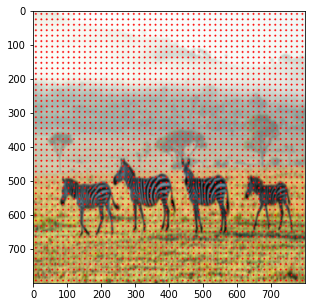

In [ ]:
# Show ctr
img_clone = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(5, 5))
for i in range(ctr.shape[0]):
    cv.circle(img_clone, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone)
plt.show()

In [ ]:
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in ctr:
  ctr_y, ctr_x = c
  for i in range(len(ratios)):
    for j in range(len(scales)):

      h = sub_sample * scales[j] * np.sqrt(ratios[i])
      w = sub_sample * scales[j] * np.sqrt(1./ratios[i])

      anchor_boxes[index, 0] = ctr_x - w/2.
      anchor_boxes[index, 1] = ctr_y - h/2.
      anchor_boxes[index, 2] = ctr_x + w/2.
      anchor_boxes[index, 3] = ctr_y + h/2.
      index += 1
  
print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -66.50966799  -37.254834    114.50966799   53.254834  ]]


210 29 573 754
317 346 498 437
226 301 589 482
45 210 770 573
344 328 472 456
280 264 536 520
152 136 664 648
362 301 453 482
317 210 498 573
226 29 589 754


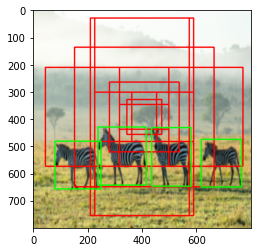

In [ ]:
img_clone = np.copy(img)

for i in range(11024, 11034):
  x1 = int(anchor_boxes[i][0])
  y1 = int(anchor_boxes[i][1])
  x2 = int(anchor_boxes[i][2])
  y2 = int(anchor_boxes[i][3])
  print(x1, y1, x2, y2)
  cv.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=3)

for i in range(len(bbox)):
  cv.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

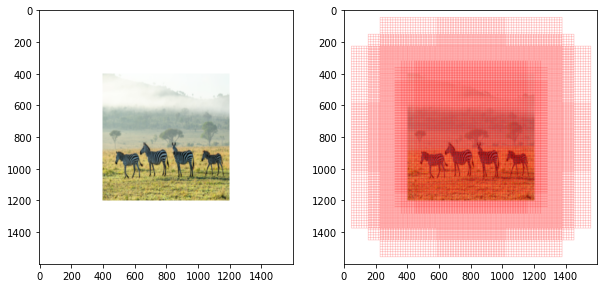

In [ ]:
# draw all anchor boxes

img_clone3 = np.copy(img)
img_clone4 = cv.copyMakeBorder(img_clone3, 400, 400, 400, 400, cv.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
  x1 = int(anchor_boxes[i][0])
  y1 = int(anchor_boxes[i][1])
  x2 = int(anchor_boxes[i][2])
  y2 = int(anchor_boxes[i][3])

  cv.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0), thickness=1)

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

#**Target Anchors**

(8940,)
(8940, 4)


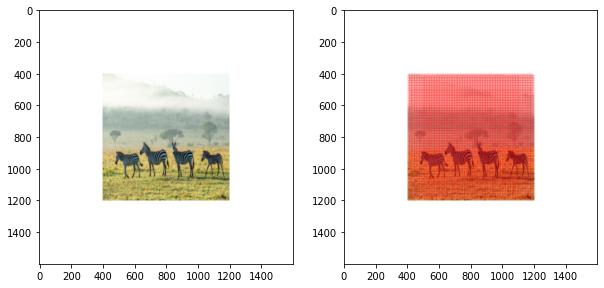

In [ ]:
# Choose anchor boxes inside the image

index_inside = np.where(
    (anchor_boxes[:, 0] >= 0) &
    (anchor_boxes[:, 1] >= 0) &
    (anchor_boxes[:, 2] <= 800) &
    (anchor_boxes[:, 3] <= 800))[0]
  
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)


# show anchor boxes images
img_clone3 = np.copy(img)
img_clone4 = cv.copyMakeBorder(img_clone3, 400, 400, 400, 400, cv.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(valid_anchor_boxes)):
# for i in range(1):
  x1 = int(valid_anchor_boxes[i][0])
  y1 = int(valid_anchor_boxes[i][1])
  x2 = int(valid_anchor_boxes[i][2])
  y2 = int(valid_anchor_boxes[i][3])

  cv.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0), thickness=1)

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

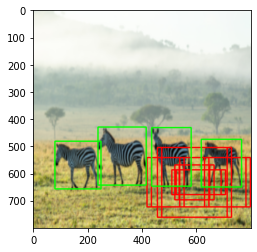

(8940, 4)
[[0.         0.         0.10914434 0.06313328]
 [0.         0.         0.22259586 0.17737345]
 [0.         0.         0.09969436 0.03216076]
 [0.         0.         0.09631042 0.12136344]
 [0.         0.         0.18580727 0.21067888]
 [0.         0.         0.07777551 0.09894223]
 [0.         0.         0.18846083 0.2136287 ]
 [0.         0.         0.05875771 0.07740004]
 [0.         0.         0.07286333 0.15178883]
 [0.         0.         0.18580727 0.21067888]]


In [ ]:
# Calculate IoUs

ious = np.empty((len(valid_anchor_boxes), 4), dtype=np.float32)
ious.fill(0)
img_clone5 = np.copy(img)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
  xa1, ya1, xa2, ya2 = anchor_box
  anchor_area = (xa2 - xa1) * (ya2 - ya1)

  # ground truth boxes
  for j, gt_box in enumerate(bbox):
    xb1, yb1, xb2, yb2 = gt_box
    box_area = (xb2 - xb1) * (yb2 - yb1)

    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    
    ious[i,j] = iou

########## Check Anchor Boxes Image
for i in range(8030,8040):
    x1 = int(valid_anchor_boxes[i][0])
    y1 = int(valid_anchor_boxes[i][1])
    x2 = int(valid_anchor_boxes[i][2])
    y2 = int(valid_anchor_boxes[i][3])

    cv.rectangle(img_clone5, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=3)

for i in range(len(bbox)):
  cv.rectangle(img_clone5, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=3)

plt.imshow(img_clone5)
plt.show()

print(ious.shape)
print(ious[8030:8040, :])

#**Sample Positive / Negative Anchor Boxes**

In [ ]:
# Anchor Boxes의 ious 중 가장 큰 값을 가지는 iou 뽑기

# 각 Truth Box 별 가장 높은 iou값의 위치
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

# 각 Truth Box 별 가장 높은 iou값
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

# 가장 높은 iou값들 추출
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[6759 5602 6171 6960]
[0.5539814 0.5752716 0.5255493 0.6325869]
[5602 5848 6094 6171 6323 6330 6337 6340 6344 6351 6417 6569 6576 6583
 6586 6590 6597 6659 6663 6666 6673 6759 6764 6770 6813 6819 6825 6827
 6831 6837 6890 6894 6896 6902 6960 6987 6992 6998 7055 7122 7188 7215
 7220 7226 7283 7416 7511]


In [ ]:
# 이미지 내에 있는 8940개의 Anchor Box가 각각 어떤 Truth Box와 연관이 많이 되어있는지
argmax_ious = ious.argmax(axis=1)
print('argmax_ious.shape : {}'.format(argmax_ious.shape))
print('argmax_ious : {}'.format(argmax_ious))
print('ious.shape : {}'.format(ious.shape))
print('index_inside.shape : {}'.format(index_inside.shape))

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print('max_ious : {}'.format(max_ious))
# for i in range(len(max_ious)):
#   print(max_ious[i])

argmax_ious.shape : (8940,)
argmax_ious : [0 0 0 ... 0 0 0]
ious.shape : (8940, 4)
index_inside.shape : (8940,)
max_ious : [0. 0. 0. ... 0. 0. 0.]


In [ ]:
# Label 정해주기
label = np.empty(len(index_inside), dtype = np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [ ]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [ ]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]
print(pos_index.shape)

if len(pos_index) > n_pos:
  disable_index = np.random.choice(pos_index,
                                   size = (len(pos_index) - n_pos),
                                   replace = True)
  print(disable_index)
  label[disable_index] = -1

n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
print(neg_index.shape)

if len(neg_index) > n_neg:
  disable_index = np.random.choice(neg_index,
                                   size = (len(neg_index) - n_neg),
                                   replace = False)
  label[disable_index] = -1

(47,)
(7508,)


In [ ]:
# Convert the format of valid anchor boxes [x1, y1, x2, y2]
# valid_anchor_boxes에서 x1, y1, x2, y2 형식으로 만들기!
# For each valid anchor box, find the ground truth object which has max_iou
max_iou_bbox = bbox[argmax_ious]
print('bbox.shape : ', bbox.shape)  # Truth Box들에 대한 좌표값
print('argmax_ious.shape : ', argmax_ious.shape)
print('max_iou_bbox.shape : ', max_iou_bbox.shape)
print('#####################################')

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
print('eps : ', eps)
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
print(dy)
print(dx)
print(dh)
print(dw)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print('anxhor_locs.shape : ', anchor_locs.shape)

bbox.shape :  (4, 4)
argmax_ious.shape :  (8940,)
max_iou_bbox.shape :  (8940, 4)
#####################################
eps :  2.220446049250313e-16
[ 5.66237852  5.66237852  5.66237852 ... -1.93901938 -1.93901938
 -1.93901938]
[10.69391783  4.07809929  2.11615299 ... -1.21315994 -1.22094538
 -1.22831936]
[0.6593293 0.6593293 0.6593293 ... 0.6593293 0.6593293 0.6593293]
[ 2.52792543  1.74583623  1.31239889 ... -1.22184236 -1.2493596
 -1.27613988]
anxhor_locs.shape :  (8940, 4)


In [ ]:
# First set the label=-1 and locations=0 of the 22500 anchor boxes, 
# and then fill in the locations and labels of the 8940 valid anchor boxes
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 8940 valid anchor boxes, and the others are marked with -1

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print('label.shape : ', label.shape)
print('index_inside.shape : ', index_inside.shape)
print('anchor_labels.shape : ', anchor_labels.shape)
print('anchor_labels[:10] : ', anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

label.shape :  (8940,)
index_inside.shape :  (8940,)
anchor_labels.shape :  (22500,)
anchor_labels[:10] :  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


#**RPN (Region Proposal Network)**

####**1) Define RPN**

In [ ]:
# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)

in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier (object or not)
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(device)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

####**2) Classification and Bounding box regression**

In [ ]:
x = conv1(output_feature.to(device))
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)

print('pred_anchor_locs.shape : ', pred_anchor_locs.shape)
print('pred_cls_scores.shape : ', pred_cls_scores.shape)

pred_anchor_locs.shape :  torch.Size([1, 36, 50, 50])
pred_cls_scores.shape :  torch.Size([1, 18, 50, 50])


In [ ]:
# Reshape Outputs

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print('pred_anchor_locs.shape : ', pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print('pred_cls_scores.shape : ', pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print('pred_cls_scores.shape : ', pred_cls_scores.shape)

pred_anchor_locs.shape :  torch.Size([1, 22500, 4])
pred_cls_scores.shape :  torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
pred_cls_scores.shape :  torch.Size([1, 22500, 2])


In [ ]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


####**3) Multi-task loss**

In [ ]:
# For classification we use cross-entropy loss

rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6985, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
# For Loc Loss
# only positive samples
pos = gt_rpn_score > 0
print('pos.shape : {}'.format(pos.shape))
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print('mask.shape : ', mask.shape)

# take those bounding boxes whick have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print('mask_loc_preds.shape, mask_loc_targets.shape', mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print('rpn_loc_loss.sum()', rpn_loc_loss.sum())

pos.shape : torch.Size([22500])
mask.shape :  torch.Size([22500, 4])
mask_loc_preds.shape, mask_loc_targets.shape torch.Size([47, 4]) torch.Size([47, 4])
rpn_loc_loss.sum() tensor(15.7555, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(4.0507, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


#**Proposal layer**

####**1) Transform anchor boxes**

In [ ]:
# Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000

nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [ ]:
# the labelled 22500 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [ ]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
print(objectness_score_numpy)

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

[ 0.00453678 -0.02655163  0.04717282 ...  0.0943011   0.06912858
 -0.02250392]
(22500, 1)


In [ ]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [ ]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


####**2) Clip the anchor boxes to the image**

In [ ]:
# clip the predcited boxes to the image

img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [ ]:
# remove predicted boxes with either height or width < threshold

hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(np.max(score))
print(keep.shape, roi.shape, score.shape)

0.2955332
(22500,) (22500, 4) (22500,)


####**3) Select top-12000 anchor boxes by objectness score**

In [ ]:
# sort all (proposal, score) pairs by score from highest to lowest
print(score)
print(np.max(score))
order = score.ravel().argsort()[::-1]
print(score[order[0]])
print(order) # index value
print(order.shape)
print()
order = order.argsort()[::-1]
print(order)
print(np.min(score))
print(score[order[0]])

[ 0.00453678 -0.02655163  0.04717282 ...  0.0943011   0.06912858
 -0.02250392]
0.2955332
0.2955332
[16378 15928 14133 ... 15923 16364 15914]
(22500,)

[19864   941   453 ...  1878 20307 11553]
-0.46782434
0.007548524


In [ ]:
# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


####**4) Non maximum suppression(select 2000 bounding boxes)**

In [ ]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes
areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [ ]:
# take the indexes of order the probability score in descending order
# non maximum suppression
# 첫번째를 기준으로 iou값을 이용해 0.7 이하 값들로 다시 계산해준다.
order = order.argsort()[::-1] # 위에서 정렬을 해줬는데 왜 order에 argsort를 해주지?
print(order)
print('order.shape : ', order.shape)
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)

  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  # print(ovr.shape)
  inds = np.where(ovr <= nms_thresh)[0]
  # print('inds.shape : {}'.format(inds.shape))
  order = order[inds + 1]
  # print('order.shape : {}\n'.format(order.shape))

print(len(keep))
keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

[6585 6135 6576 ... 8366 6571 6121]
order.shape :  (12000,)
2733
2000 (2000, 4)


#**Proposal Target layer**

####**1) Calculate IoUs**

In [ ]:
n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [ ]:
# fine the iou of each ground truth object with the region proposals
print('len(roi) : ', len(roi))
print('bbox.shape[0] : ', bbox.shape[0])
ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print(ious.shape)

len(roi) :  2000
bbox.shape[0] :  4
(2000, 4)


In [ ]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[3 3 0 ... 0 0 0]
[0.34780213 0.05239911 0.         ... 0.         0.         0.        ]
[1 1 1 ... 1 1 1]


####**2) Select foreground (positive) samples**

In [ ]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

19
[1035  744 1094  842 1015  920  928 1034  998  999  858  931 1079 1099
  817 1142  926  942  914]


####**3) Select background negative) samples**

In [ ]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

109
[1616 1415 1372 1843  893 1134 1986 1249   24 1967  972 1124 1234  347
 1206 1619 1241  834  633  947 1664 1893   43 1885 1554  344 1456  100
 1109  866  908 1014 1284 1116 1830 1539 1264 1045   72 1808  741  851
 1757   19  176  245  888  323  982  660 1064  215  430  753  799  142
  629 1225 1369  114  270  399  864 1747  280  384  990 1325  378 1909
   91 1671  941  688 1969 1398 1752  112  135  814  555  540 1883  748
  219 1642  162 1216  328  116 1663  693  948 1547  393  839 1251   49
 1402  248  423 1320  663 1704  988 1382  731 1051  618]


####**4) Visualization**

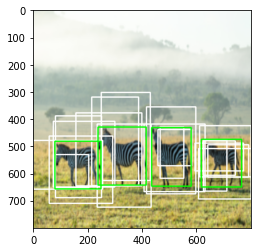

In [ ]:
# display RoI samples with positive

img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)
  
for i in range(len(bbox)):
  cv.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

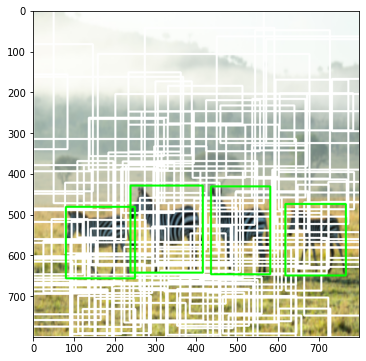

In [ ]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for i in range(len(bbox)):
  cv.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

####**5) Gather positive/negative samples**

In [ ]:
# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [ ]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to 
# anchor boxes

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [ ]:
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height 

In [ ]:
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


#**RoI Pooling**

####**1) Concatenate labels with bbox coordinates**

In [ ]:
# Take out the features of 128 ROI samples and 
# use max pooling to adjust to the same size, H=7, W=7 (ROI Pooling)

rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [ ]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


####**2) RoI pooling**

In [ ]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = output_feature.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())

torch.Size([128, 512, 7, 7])


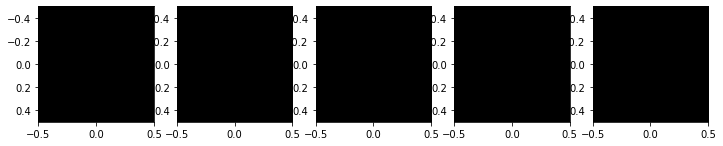

In [ ]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_feature.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [ ]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


#**Fast R-CNN**

####**1) Classifier and Bounding box regressor**

In [ ]:
# 128 boxes + features (7x7x512) of ROI samples are sent to 
# Detection network to predict the objects bounding box and clas of the input image

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device) # 1 class, 1 background, 4 coordiinates
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(device) # 1 class, 1 background

In [ ]:
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [ ]:
# Calculate the loss of Fast RCNN based on the gt bboxes and features (h, w, d=512) 
# corresponding to these 128 ROIs

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [ ]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

####**2) Classification loss**

In [ ]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


####**3) Regression loss**

In [ ]:
# regression loss

n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [ ]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [ ]:
# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [ ]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.data.cpu() - mask_loc_preds.data.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([19, 4]) torch.Size([19, 4])
tensor(2.4120, dtype=torch.float64)


####**4) Multi-task loss**

In [ ]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)
print(roi_loss.dtype)

total_loss = rpn_loss.data.cpu() + roi_loss.data.cpu()
print(total_loss)

tensor([[0.6812, 0.7058, 1.2219, 1.1730],
        [0.7157, 0.9124, 1.3792, 0.6830],
        [0.7582, 0.8111, 0.7139, 1.2678],
        [0.6974, 0.7491, 0.9300, 1.0748],
        [0.7267, 0.9363, 1.3018, 0.6802],
        [0.7591, 0.6801, 2.0547, 0.6981],
        [0.6829, 0.9008, 1.1041, 2.6066],
        [0.6920, 0.7086, 1.5097, 0.9077],
        [0.7523, 0.8107, 1.4918, 0.9730],
        [0.6853, 0.7271, 0.7437, 1.7372],
        [0.8213, 0.8649, 0.8478, 1.5918],
        [0.6897, 0.7805, 0.7461, 1.4951],
        [0.7558, 0.9951, 0.6884, 2.2629],
        [0.8442, 0.7192, 1.5726, 0.7910],
        [0.9635, 0.6918, 1.6072, 0.6803],
        [0.7262, 0.9203, 0.7565, 1.2522],
        [0.8578, 0.6979, 0.7522, 1.7732],
        [0.7059, 0.6817, 2.1637, 0.6987],
        [0.7020, 0.7064, 1.6182, 1.0422]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
torch.float64
tensor([[4.7319, 4.7565, 5.2726, 5.2237],
        [4.7664, 4.9631, 5.4299, 4.7337],
        [4.8089, 4.8618, 4.7646, 5.3185],
        [